# Crowd detection evaluation

This notebook aims at showing what kind of graph you can draw thank's to Lours crowd detection evaluator, as special case of detection evaluation

In [1]:
%load_ext autoreload

%autoreload 2
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from lours.dataset import from_coco_keypoints
from lours.evaluation.detection import CrowdDetectionEvaluator as cde

warnings.simplefilter(action="ignore", category=FutureWarning)

## Loading the dataset and the predictions

Note that they are both treated as datasets at first, and only when creating the eval object we have a detection evaluator

As a second Note, you can add several prediction datasets at the same time

In [2]:
crowd_gt = from_coco_keypoints(
    "../../test_lours/test_data/coco_eval/instances_crowd.json"
)
crowd_preds = from_coco_keypoints(
    "../../test_lours/test_data/coco_eval/instances_crowd_predictions.json"
)
evaluator = cde(groundtruth=crowd_gt, predictions=crowd_preds)

In [3]:
evaluator

## Computing count error metrics

Here, we compute count error with absolute error (in number of person detected) and relative error (relative to the actual number of person).

- Absolute error is computed with Mean Absolute Error (MAE), Root of Mean Square Error (RMSE), standard deviation of absolute error (std) and different quantiles of errors. the quantile at 50% (q0.50) is also known as the median of errors. If a model is well behaved, the minimum MAE should be at the same threshold as when the median of absolute error is 0.
- Relative error is computed the same way. Mean Relative Error (MRE) and Root of Mean Square Relative Error (RMSRE) replace MAE and RMSE.

More formally, for a dataset $D$ of $N$ images, with each image $I_i$ having a count $c_{I_i}$, and the corresponding prediction count $\widehat{c}(I_i, t)$ with a model $\widehat{c}$ and a detection threshold $t$. The count is thus the number of detections in a particular image such that their confidence if above the threshold $t$.

We then get the following formulae:

$$ MAE(\widehat{c}, t) = \frac{1}{N}\sum_{i = 0}^N\left|c_{I_i} - \widehat{c}(I_i, t)\right| = \mathbb{E}_{I \sim D}\left|c_I - \widehat{c}(I, t)\right|$$
$$ MAE(\widehat{c}) = min_{t} MAE(\widehat{c}, t)$$


Similarly with other metrics :

$$MRE(\widehat{c}, t) = \frac{1}{N}\sum_{i = 0}^N\left|\frac{c_{I_i} - \widehat{c}(I_i, t)}{c_{I_i}}\right|$$

$$RMSE(\widehat{c}, t) = \sqrt{\frac{1}{N}\sum_{i = 0}^N\left(c_{I_i} - \widehat{c}(I_i, t)\right)^2}$$

$$RMSRE(\widehat{c}, t) = \sqrt{\frac{1}{N}\sum_{i = 0}^N\left(\frac{c_{I_i} - \widehat{c}(I_i, t)}{c_{I_i}}\right)^2}$$

For quantiles, we compute the quantiles of algebraic error / relative error distribution : for a share $\alpha \in [0,1]$, we compute the count error $e$ below which $\alpha$ of the count predictions on images used for evaluation were for the pair $\widehat{c}, t$

$$q\alpha(\widehat{c}, t) = q(\widehat{c}, t, \alpha) = e \text{ such that } \mathop{\mathbb{E}}_{I \sim D}\delta_{\mathbb{R}^+}\left(c_{I} - \widehat{c}(I, t) - e\right) = \alpha$$

$$qR\alpha(\widehat{c}, t) = qR(\widehat{c}, t, \alpha) = e \text{ such that } \mathop{\mathbb{E}}_{I \sim D}\delta_{\mathbb{R}^+}\left(\frac{c_{I} - \widehat{c}(I, t)}{c_{I}} - e\right) = \alpha$$


where $\delta_{\mathbb{R}^+}$ is the characteristic function of $\mathbb{R}^+$

$$ \begin{array}{rccc}\delta_{\mathbb{R}^+}: & \mathbb{R} & \rightarrow & \{0,1\} \\ & x & \mapsto & \left\{\begin{array}{l} 1 \text{ if } x > 0 \\ 0 \text{ else} \end{array}\right. \end{array}$$

In addition to these curves, we get the detailed errors, that is the error per image, per confidence threshold. This will help us doing statistics with seaborn.

In [4]:
curves, detailed_errors = evaluator.compute_count_error(
    groups=(), quantiles=np.linspace(0.1, 0.9, 7)
)

  0%|          | 0/300 [00:00<?, ?it/s]

Let's display the relative and absolute error tables

In [5]:
curves["relative"]

,MRE,RMSRE,std,q0.10,q0.23,q0.37,q0.50,q0.63,q0.77,q0.90,model
confidence,,,,,,,,,,,
0.00,0.649522,0.730219,0.335279,0.279273,0.413445,0.513316,0.613915,0.704724,0.806905,1.098196,predictions
0.01,0.649522,0.730219,0.335279,0.279273,0.413445,0.513316,0.613915,0.704724,0.806905,1.098196,predictions
0.02,0.649522,0.730219,0.335279,0.279273,0.413445,0.513316,0.613915,0.704724,0.806905,1.098196,predictions
0.03,0.649522,0.730219,0.335279,0.279273,0.413445,0.513316,0.613915,0.704724,0.806905,1.098196,predictions
0.04,0.649522,0.730219,0.335279,0.279273,0.413445,0.513316,0.613915,0.704724,0.806905,1.098196,predictions
...,...,...,...,...,...,...,...,...,...,...,...
0.96,0.537497,0.556097,0.142859,-0.699791,-0.651725,-0.598796,-0.549580,-0.504594,-0.426347,-0.333964,predictions
0.97,0.593507,0.611315,0.146721,-0.755856,-0.709297,-0.661932,-0.619557,-0.561183,-0.484848,-0.392799,predictions
0.98,0.667382,0.683765,0.149028,-0.836331,-0.781949,-0.749009,-0.697289,-0.647355,-0.561885,-0.459282,predictions


In [6]:
curves["absolute"]

,MAE,RMSE,std,q0.10,q0.23,q0.37,q0.50,q0.63,q0.77,q0.90,model
confidence,,,,,,,,,,,
0.00,364.906667,531.806337,387.576233,60.0,111.000000,172.633333,238.0,337.833333,476.233333,796.5,predictions
0.01,364.906667,531.806337,387.576233,60.0,111.000000,172.633333,238.0,337.833333,476.233333,796.5,predictions
0.02,364.906667,531.806337,387.576233,60.0,111.000000,172.633333,238.0,337.833333,476.233333,796.5,predictions
0.03,364.906667,531.806337,387.576233,60.0,111.000000,172.633333,238.0,337.833333,476.233333,796.5,predictions
0.04,364.906667,531.806337,387.576233,60.0,111.000000,172.633333,238.0,337.833333,476.233333,796.5,predictions
...,...,...,...,...,...,...,...,...,...,...,...
0.96,299.643333,417.398734,291.063514,-629.6,-383.033333,-279.366667,-214.0,-158.266667,-108.766667,-65.9,predictions
0.97,336.140000,472.472765,332.579480,-699.3,-422.933333,-319.366667,-227.5,-174.266667,-119.533333,-72.9,predictions
0.98,382.430000,540.884285,383.134980,-784.3,-487.700000,-354.100000,-253.5,-193.633333,-136.533333,-82.4,predictions


And now the detailed errors table which is much larger, but can be used to reconstruct the aforementioned error tables

In [7]:
detailed_errors

count  gt_count  error  rel_error  abs_error  \
image_id confidence                                                 
0        0.00        958.0       419  539.0   1.286396      539.0   
         0.01        958.0       419  539.0   1.286396      539.0   
         0.02        958.0       419  539.0   1.286396      539.0   
         0.03        958.0       419  539.0   1.286396      539.0   
         0.04        958.0       419  539.0   1.286396      539.0   
...                    ...       ...    ...        ...        ...   
299      0.96        112.0       261 -149.0  -0.570881      149.0   
         0.97        101.0       261 -160.0  -0.613027      160.0   
         0.98         80.0       261 -181.0  -0.693487      181.0   
         0.99         56.0       261 -205.0  -0.785441      205.0   
         1.00          0.0       261 -261.0  -1.000000      261.0   

                     abs_rel_error  sq_error  sq_rel_error        model  
image_id confidence                                                      
0        0.00             1.286396  290521.0      1.654815  predictions  
         0.01             1.286396  290521.0      1.654815  predictions  
         0.02             1.286396  290521.0      1.654815  predictions  
         0.03             1.286396  290521.0      1.654815  predictions  
         0.04             1.286396  290521.0      1.654815  predictions  
...                            ...       ...           ...          ...  
299      0.96             0.570881   22201.0      0.325905  predictions  
         0.97             0.613027   25600.0      0.375802  predictions  
         0.98             0.693487   32761.0      0.480924  predictions  
         0.99             0.785441   42025.0      0.616917  predictions  
         1.00             1.000000   68121.0      1.000000  predictions  

[30300 rows x 9 columns]

## Using Seaborn with detailed errors

The following graph can you grasp what quantiles are related to.

The graph shows an histogram of algebraic error counts throughout the whole dataset, for the confidence thresholds 0.5 and 0.3

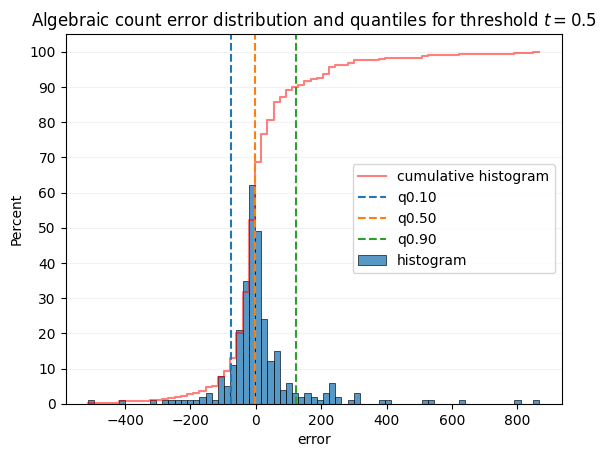

In [8]:
sns.histplot(
    detailed_errors.xs(0.5, level="confidence")["error"],
    cumulative=True,
    label="cumulative histogram",
    fill=False,
    stat="percent",
    element="step",
    color="red",
    alpha=0.5,
)
dist = sns.histplot(
    detailed_errors.xs(0.5, level="confidence")["error"],
    label="histogram",
)
ymin, ymax = dist.get_ylim()
quantiles = curves["absolute"].loc[0.5, ["q0.10", "q0.50", "q0.90"]]
for name, q in quantiles.items():
    plt.plot([q, q], [ymin, ymax], label=name, linestyle="dashed")
plt.ylim(ymin, ymax)
plt.grid(axis="y", color="0.95")
dist.set_axisbelow(True)
plt.yticks(range(0, 110, 10))
plt.legend()
plt.title("Algebraic count error distribution and quantiles for threshold $t = 0.5$")
plt.show()

Next Cell will plot the same distribution but as a 2D heatmap, with y axis set to the threshold.
Each vertical slice will give the graph above.

You can notice some image outliers where the detector consistently overestimate or underestimate the count by a very large margin, that might be interesting to check out.

<Axes: xlabel='confidence', ylabel='error'>

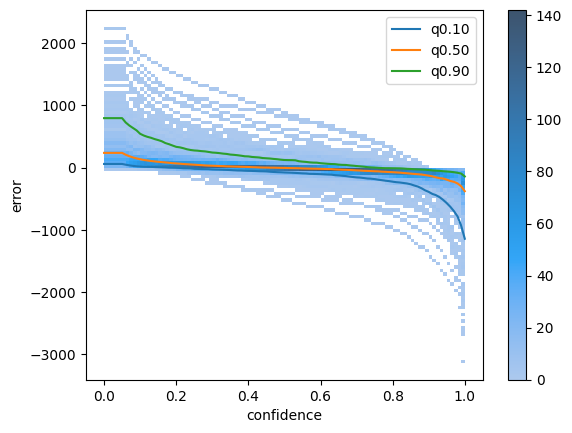

In [9]:
ax = sns.histplot(detailed_errors, x="confidence", y="error", bins=100, cbar=True)
quantiles = curves["absolute"][["q0.10", "q0.50", "q0.90"]]
quantiles.plot(ax=ax)

Same 2D hist plot can be made with absolute error instead of algebraic error

<Axes: xlabel='confidence', ylabel='abs_error'>

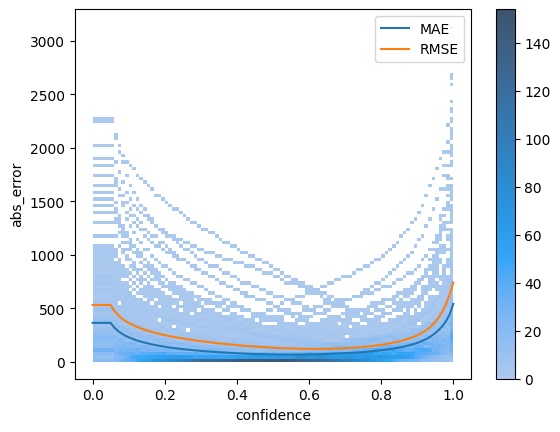

In [10]:
ax = sns.histplot(detailed_errors, x="confidence", y="abs_error", bins=100, cbar=True)
curves["absolute"][["MAE", "RMSE"]].plot(ax=ax)

Finally, we can simply use the `lineplot` function to plot the error distribution across thresholds. The "pi" error bar is for percentage interval. See more info in [seaborn documentation](https://seaborn.pydata.org/tutorial/error_bars.html)

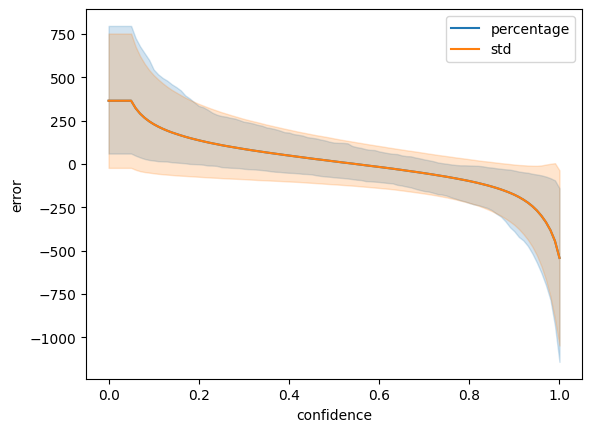

In [11]:
sns.lineplot(
    detailed_errors, x="confidence", y="error", errorbar=("pi", 80), label="percentage"
)
sns.lineplot(detailed_errors, x="confidence", y="error", errorbar="sd", label="std")
plt.legend()

## Manual plotting

Here, we use directly matplotlib and pandas to plot the different curves.

MAE and RMSE give use info about lowest possible error wrt confidence threshold, std give use info about the expected variation of count quality across the different samples of the validation set.

Ideally, you should aim for low Error AND low STD.

First cell uses Absolute metrics (MAE, RMSE) while second cell uses Relative metrics (MRE, RMSRE)

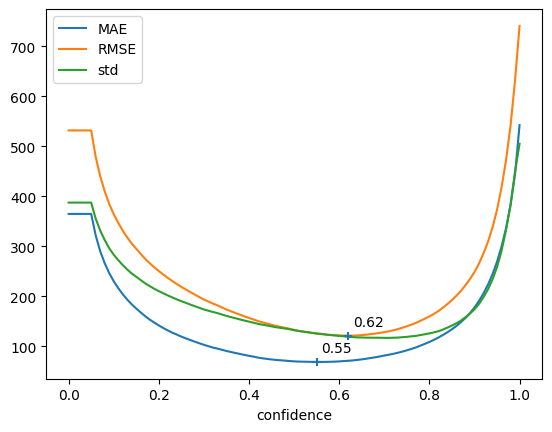

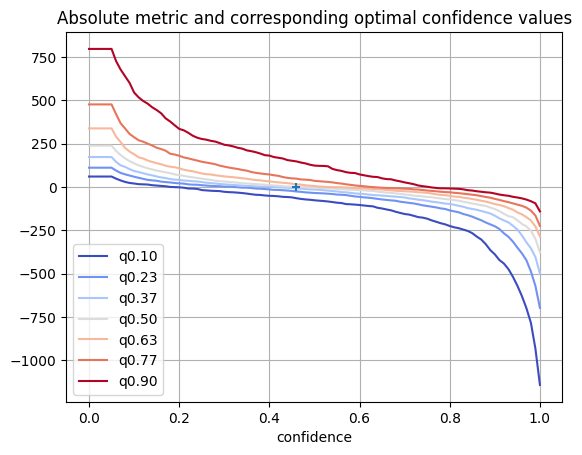

In [12]:
abs_curves = curves["absolute"]
error = abs_curves[["MAE", "RMSE"]]

fig, ax = plt.subplots()
abs_curves[["MAE", "RMSE", "std"]].plot(ax=ax)
plt.scatter(error.idxmin(), error.min(), marker="+", zorder=10)
for x, y in zip(error.idxmin(), error.min()):
    ax.annotate(f"{x:.2f}", [x + 0.01, y + 20])
fig, ax = plt.subplots()
quantiles = [c for c in abs_curves.columns if c.startswith("q")]
abs_curves[quantiles].plot(ax=ax, colormap="coolwarm")
plt.grid()

abs_median = abs_curves["q0.50"].abs()
plt.scatter(abs_median.idxmin(), abs_median.min(), marker="+", zorder=10)
plt.title("Absolute metric and corresponding optimal confidence values")
plt.show()

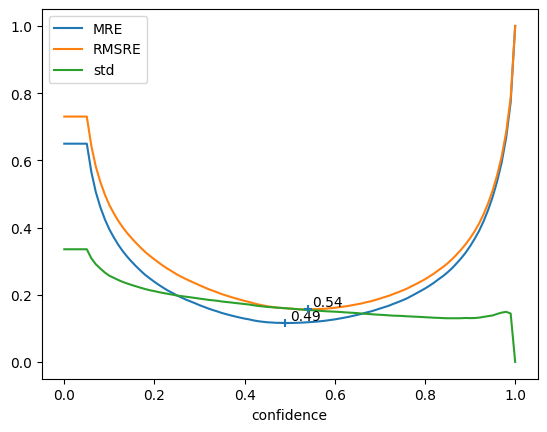

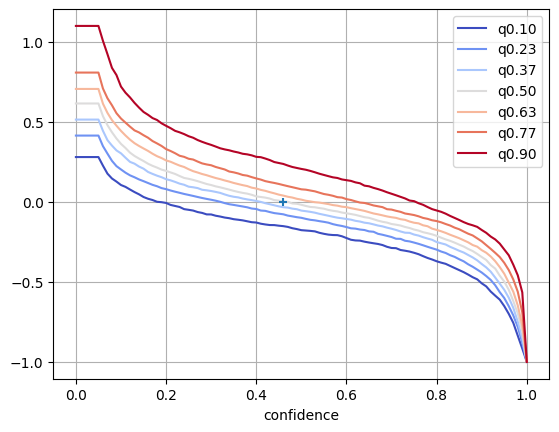

In [13]:
rel_curves = curves["relative"]
error = rel_curves[["MRE", "RMSRE"]]

fig, ax = plt.subplots()
rel_curves[["MRE", "RMSRE", "std"]].plot(ax=ax)
plt.scatter(error.idxmin(), error.min(), marker="+", zorder=10)
for x, y in zip(error.idxmin(), error.min()):
    ax.annotate(f"{x:.2f}", [x + 0.01, y + 0.01])
fig, ax = plt.subplots()
quantiles = [c for c in rel_curves.columns if c.startswith("q")]
rel_curves[quantiles].plot(ax=ax, colormap="coolwarm")
plt.grid()

abs_median = rel_curves["q0.50"].abs()
plt.scatter(abs_median.idxmin(), abs_median.min(), marker="+", zorder=10)
plt.show()